<h1><center>Data Camp Project</center></h1>
<h1><center>Spotify genres challenge : predicting the genres of a track</center></h1>
<br>
<div style="text-align: center">
    <em>
        <i>Authors: Nadir Abdou, Raphaël Boige, Mickael Corroyer, Ulysse Demay, Nathan Xerri</i><br>
    </em>
</div>

## Table of contents

1. [Introduction](#Introduction)
2. [Data exploration](#Data_exploration)
    - [Python Prerequisites](#prerequisites)
    - [Download the data](#Download_data)
    - [Load the data](#Load_data)
    - [The features](#features)
    - [The genres](#genres)
4. [Performance metric](#metric)
3. [Submission](#submission) 

## Introduction <a class="anchor" id="Introduction"></a>

Every month in 2020, 138 million different people actively used Spotify to listen to their music, and 44% of them use it on a daily basis. For the past decade, the streaming applications, such as Spotify, Deezer, Apple Music, have taken a leap never accounted before in the music industry.
For most now, it is the only way they ever listen to music. Its variety and large panel of choice (over 50 million different tracks available) make of Spotify the best way to efficiently represent the musical tastes of a large part of the population.

As it is explained further down, Spotify can store in its API the genres of the tracks. For now, genres can be assigned to the artist itself, or to an album, but not to a specific track. This is why Spotify does not have track genres so to speak.
Our aim with this study is to make an algorithm capable of predicting what are the genres of a specific track, given its multiple audio data. They are widely explored and described in the part about the features, further down.
Another argument to make such an algorithm would be that the genres are still added manually by the Spotify developpers. Such an algorithm would release them from this exhausting labor. Moreover, since they are added this way, much of the artists and albums in Spotify do not have a genre assigned, because they are less known to the public, so less prioritized in the assignment.

For this study, we have specificially chosen a smaller range of genres than the total panel of Spotify (there are over 5000 different genres) to make the prediction feasible, and the dataset not too large.

The problem is thus the following: Given multiple tracks with various audio features, and a determined range of music genres, make a classifier able to predict the genres of a specific track (with its proper audio features).

## Data Exploration <a class="anchor" id="Data_exploration"></a>

### Prerequisites<a class="anchor" id="prerequisites"></a>

- Python >= 3.7
- numpy
- pandas
- ast
- seaborn
- matplotlib
- random
- scikit-learn
- scikit-multilearn

In [40]:
import pandas as pd
import ast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import jaccard_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from IPython.display import Image
from IPython.core.display import HTML 

from skmultilearn.model_selection import iterative_train_test_split

from problem import EMDScore

### Download the data<a class="anchor" id="Download_data"></a>

In order to locally download the data for the challenge you need to download it using these 4 links:

- X_train: https://lufi.rezel.net/r/9e1y73tnKZ#veGDCVU419FQL6c7oZfz2f7HAr7RoxddPlQZcFyJVdI=

- y_train: https://lufi.rezel.net/r/geTCfJU5Fc#0rK1Yrmh8mSzUvdTWA3pj0Ec28lgr4qV4ZrLsXKzWt0=

- X_test: https://lufi.rezel.net/r/fsAUYoz7KF#rg/+niesg9svKzozEJ8JBvSy3yDpKHU+t3djv54/UEk=

- y_test: https://lufi.rezel.net/r/5UuqDr45Wo#lCF2mQHDrykyvBdW2NU2a95MqggzWJ/l+zNMGQyaKmc=

Once it is done put them in the `/data` folder.

If it is unavailable run the entire `/data/data_constructor.ipynb` notebook and then the `split_dataset.py` Python script. Be patient, this may take more than one hour since the dataset size is approximatively 2 GB. Once you have done this pay only attention to the files `/data/X_train.csv`, `/data/y_train.csv`, `/data/X_test.csv` and `/data/y_test.csv`

### Load the data <a class="anchor" id="Load_data"></a>

To obtain the data for this challenge we have used the Python library `spotipy` using the Spotify API that is provided for free for anyone having a Spotify account. We have selected all the tracks of 7 playlists of various genres of the website http://everynoise.com/ and collected our features among the ones provided by Spotify through the `audio_analysis` and the `audio_features`.

The genres of each track have been collected thanks to the genres of the album when available and the genres of the artist if not. Then we have considered only the 25 most common genres to ensure that a sufficient number of tracks belong to each genre. For each track its genres are provided as a list so to retrieve the labels of each track as binary lists of size 25 (each cell containing 1 if it belongs to the genre represented by index, 0 if not) we have used the `MultiLabelBinarizer` class provided by `scikit-learn`.

As a result we have obtained 6071 tracks with their features and their uri (each track is identified by Spotify thanks to a unique uri) which we have removed from the dataset to "anonymize" the tracks. We have separated this dataset using the function `iterative_train_test_split` provided by `scikit-multilearn`, which is suited for multi-label classification problems. Indeed, it has the particularity to split the dataset using iterative stratification so it tries to keep the genres distribution when separating train an test. We obtained 3 datasets: 2846 tracks for the local train dataset (`/data/X_train.csv` and `/data/y_train.csv`), 1221 for the local test dataset (`/data/X_test.csv` and `/data/y_test.csv`) and 2004 for the online test dataset (the one that is used by the server to compute leaderboard scores).

(If you want practical details please look at the `data_constructor.ipynb` Jupyter notebook and the `split_dataset.py` Python script)

In [2]:
X_df = pd.read_csv('data/X_train.csv', sep=';').drop(['Unnamed: 0'], axis=1)
y_df = pd.read_csv('data/y_train.csv', sep=';').drop(['Unnamed: 0'], axis=1)

In [3]:
X_df.head(3)

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,mode,duration_ms,time_signature,key,sections,segments,loudness
0,0.259,0.437,0.0386,0.1020,0.000001,0.1060,0.0951,180.042,0,239000,4,11,"[{'start': 0.0, 'duration': 10.22381, 'confide...","[{'start': 0.0, 'duration': 0.20308, 'confiden...",-6.589
1,0.664,0.708,0.0474,0.0337,0.000000,0.0841,0.7420,103.070,1,174800,4,8,"[{'start': 0.0, 'duration': 5.27332, 'confiden...","[{'start': 0.0, 'duration': 0.19188, 'confiden...",-4.154
2,0.697,0.683,0.1170,0.0372,0.000000,0.1370,0.6030,96.133,0,186987,4,1,"[{'start': 0.0, 'duration': 14.72376, 'confide...","[{'start': 0.0, 'duration': 0.20313, 'confiden...",-2.881


In [4]:
y_df.head(3)

,rock,pop,latin,edm,rap,dance pop,pop dance,electro house,alternative metal,hip hop,...,post-teen pop,album rock,latin pop,southern hip hop,hard rock,gangster rap,electropop,big room,classical,reggaeton
0,0,1,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### The features<a class="anchor" id="features"></a>

In [5]:
X_df.columns

Index(['danceability', 'energy', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'mode',
       'duration_ms', 'time_signature', 'key', 'sections', 'segments',
       'loudness'],
      dtype='object')

We have 15 features for this challenges: 13 being static features and 2 being sequential features.

#### The static features

We have 13 static features provided by Spotify `audio_features`:
1. **danceability** (float): Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
2. **energy** (float): Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
3. **speechiness** (float): Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
4. **acousticness** (float): A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
5. **instrumentalness** (float): Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
6. **liveness** (float): Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
7. **valence** (float): A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
8. **tempo** (float): The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
9. **mode** (int): Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
10. **duration_ms** (int): The duration of the track in milliseconds.
11. **time_signature** (int): 	An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).
12. **key** (int): The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
13. **loudness** (float): The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

(descriptions provided at https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)

First, we can check the number of tracks having common genres:

In [6]:
genre_1 = 'pop'
genre_2 = 'rap'
nb_common = len(y_df.loc[(y_df[genre_1] == 1) & (y_df[genre_2] == 1)])
print('Number of', genre_1, 'and', genre_2, 'tracks:', nb_common)

Number of pop and rap tracks: 22


Now, let's visualize the repartition of a given feature according to a subset of genres:

In [7]:
def plot_feature_hist(feature, labels, bins=None, colors=None):
    if colors is None:
        colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) 
              for i in range(len(labels))]
    if bins is None:
        bins = np.linspace(X_df[feature].min(), X_df[feature].max(), 15)
    for label, color in zip(labels, colors):
        plt.hist(X_df[y_df[label] == 1][feature].values, density=True, bins=bins, 
                 alpha=0.5, color=color, label=label)
        plt.legend()
    plt.xlabel(feature)
    plt.ylabel('density')
    plt.title('Feature repartition according to genres')
    plt.show()

In [8]:
# disjoint classes
labels = ['edm', 'rock', 'latin']

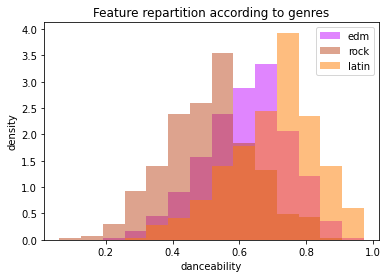

In [9]:
feature = 'danceability'
plot_feature_hist(feature, labels)

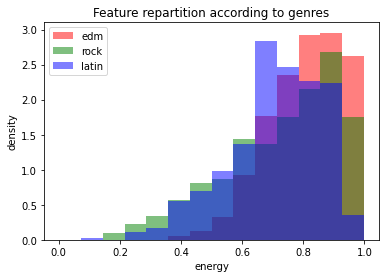

In [10]:
feature = 'energy'
colors = ['r', 'g', 'b']
plot_feature_hist(feature, labels, colors=colors)

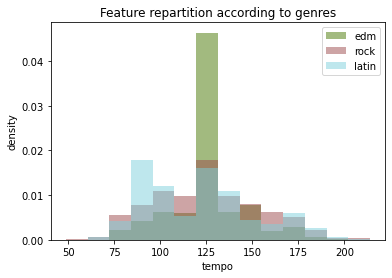

In [11]:
feature = 'tempo'
plot_feature_hist(feature, labels)

In [12]:
labels = ['rock', 'rap']
colors = ['r', 'b']

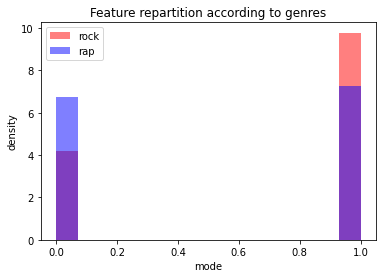

In [13]:
feature = 'mode'
plot_feature_hist(feature, labels, colors=colors)

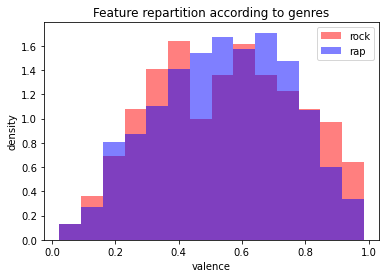

In [14]:
feature = 'valence'
plot_feature_hist(feature, labels, colors=colors)

Then, we can plot pairwise relationships between a subset of the dataset features:

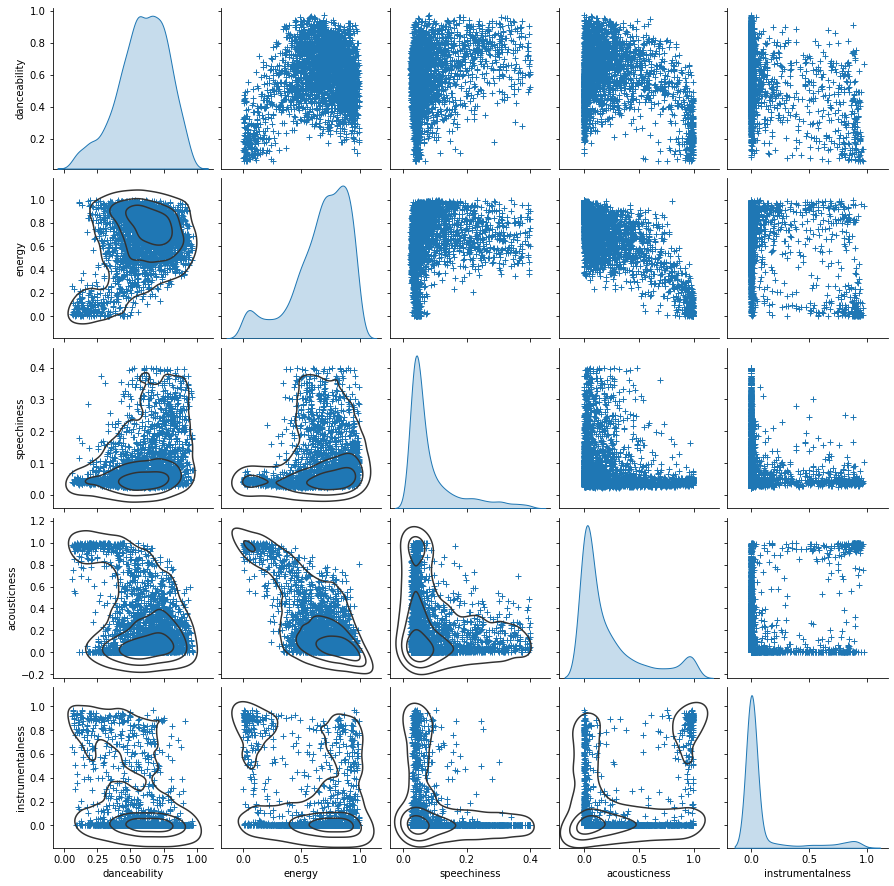

In [15]:
features = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness']
plot = sns.pairplot(X_df, vars=features, plot_kws=dict(marker="+", linewidth=1), diag_kind='kde')
plot.map_lower(sns.kdeplot, levels=4, color=".2")

#### The sequential features

We have 2 sequential features provided by Spotify `audio_analysis`:
1. **sections** (an array of section objects): Sections are defined by large variations in rhythm or timbre, e.g. chorus, verse, bridge, guitar solo, etc. Each section contains its own descriptions of tempo, key, mode, time_signature, and loudness. Each section object is composed of 12 features:
    - *start* (float): The starting point (in seconds) of the section.
    - *duration* (float): The duration (in seconds) of the section.
    - *confidence* (float): The confidence, from 0.0 to 1.0, of the reliability of the section’s “designation”.
    - *loudness* (float): The overall loudness of the section in decibels (dB). Loudness values are useful for comparing relative loudness of sections within tracks.
    - *tempo* (float): The overall estimated tempo of the section in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
    - *tempo_confidence* (float): The confidence, from 0.0 to 1.0, of the reliability of the tempo. Some tracks contain tempo changes or sounds which don’t contain tempo (like pure speech) which would correspond to a low value in this field.
    - *key* (int): The estimated overall key of the section. The values in this field ranging from 0 to 11 mapping to pitches using standard Pitch Class notation (E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on). If no key was detected, the value is -1.
    - *key_confidence* (float): The confidence, from 0.0 to 1.0, of the reliability of the key. Songs with many key changes may correspond to low values in this field.
    - *mode* (int):	Indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. This field will contain a 0 for “minor”, a 1 for “major”, or a -1 for no result. Note that the major key (e.g. C major) could more likely be confused with the minor key at 3 semitones lower (e.g. A minor) as both keys carry the same pitches.
    - *mode_confidence* (float): The confidence, from 0.0 to 1.0, of the reliability of the mode.
    - *time_signature* (int): An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of “3/4”, to “7/4”.
    - *time_signature_confidence* (float): The confidence, from 0.0 to 1.0, of the reliability of the time_signature. Sections with time signature changes may correspond to low values in this field.
    
    
2. **segments** (an array of segment objects): Audio segments attempts to subdivide a song into many segments, with each segment containing a roughly consistent sound throughout its duration. Each segment object is composed of 9 features:
    - *start* (float): The starting point (in seconds) of the segment.
    - *duration* (float): The duration (in seconds) of the segment.
    - *confidence* (float): The confidence, from 0.0 to 1.0, of the reliability of the segmentation. Segments of the song which are difficult to logically segment (e.g: noise) may correspond to low values in this field.
    - *loudness_start* (float): The onset loudness of the segment in decibels (dB). Combined with loudness_max and loudness_max_time, these components can be used to describe the “attack” of the segment.
    - *loudness_max* (float): The peak loudness of the segment in decibels (dB). Combined with loudness_start and loudness_max_time, these components can be used to describe the “attack” of the segment.
    - *loudness_max_time* (float): The segment-relative offset of the segment peak loudness in seconds. Combined with loudness_start and loudness_max, these components can be used to describe the “attack” of the segment.
    - *loudness_end* (float): The offset loudness of the segment in decibels (dB). This value should be equivalent to the loudness_start of the following segment.
    - *pitches* (array of floats): A “chroma” vector representing the pitch content of the segment, corresponding to the 12 pitch classes C, C#, D to B, with values ranging from 0 to 1 that describe the relative dominance of every pitch in the chromatic scale.
    - *timbre* (array of floats): Timbre is the quality of a musical note or sound that distinguishes different types of musical instruments, or voices. Timbre vectors are best used in comparison with each other.

(descriptions provided at https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-analysis/)

In [16]:
X_df['sections'] = X_df['sections'].apply(ast.literal_eval)
X_df['segments'] = X_df['segments'].apply(ast.literal_eval)

##### Sections

To begin with let us investigate the features of the section objects, which are dictionnaries containing lot of features about the section they correspond to. First we can print several statistic indicators concerning the length of the `sections` feature of each track.

In [17]:
X_df['sections'].apply(lambda x: len(x)).describe()

count    2846.000000
mean       10.636683
std         3.809263
min         4.000000
25%         8.000000
50%        10.000000
75%        12.000000
max        49.000000
Name: sections, dtype: float64

Now we are going to visualize the tempo, key, mode and time signature and their respective confidence as a curve indexed temporally by the `sections` feature. We plot these features for 4 tracks chosen randomly and we add the genres of the considered track in the graph title so it is possible to guess a link between the curves' shapes and the genres

In [18]:
# we randomly choose 4 tracks
tracks = np.random.choice(range(0, len(X_df)), size=4, replace=False)
genres = [y_df.columns[np.array(y_df.iloc[i].tolist()) > 0].tolist() for i in tracks]

In [19]:
"""
Function used to visualize a feature of a section object with its confidence.
"""
def visualize(feature, feature_confidence, feature_name):
    fig = plt.figure(figsize=(15, 10))
    outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)

    for i in range(4):
        inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.2)
    
        ax1 = plt.Subplot(fig, inner[0])
        ax1.plot(feature[i])
        ax1.set_ylabel(feature_name)
        fig.add_subplot(ax1)
        ax1.set_title("Track %d: " % i + str(genres[i]))
    
        ax2 = plt.Subplot(fig, inner[1])
        ax2.plot(feature_confidence[i], 'orange')
        ax2.set_ylabel("Confidence")
        fig.add_subplot(ax2)

    fig.suptitle(feature_name + " and its confidence", fontsize=16)
    plt.show()

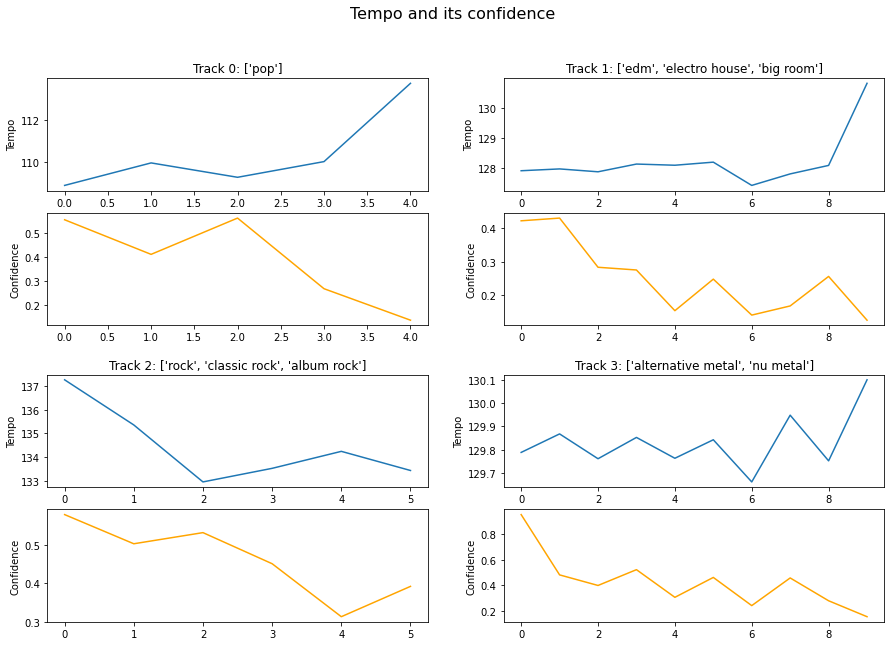

In [20]:
tempos = [[x['tempo'] for x in X_df['sections'][i]] for i in tracks]
tempos_confidence = [[x['tempo_confidence'] for x in X_df['sections'][i]] for i in tracks]

visualize(tempos, tempos_confidence, "Tempo")

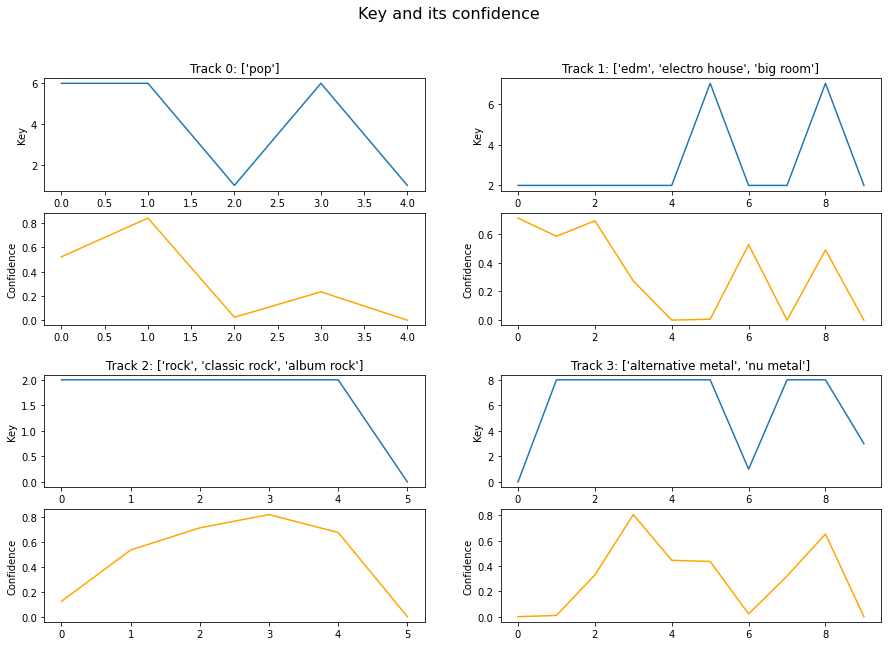

In [21]:
keys = [[x['key'] for x in X_df['sections'][i]] for i in tracks]
keys_confidence = [[x['key_confidence'] for x in X_df['sections'][i]] for i in tracks]

visualize(keys, keys_confidence, "Key")

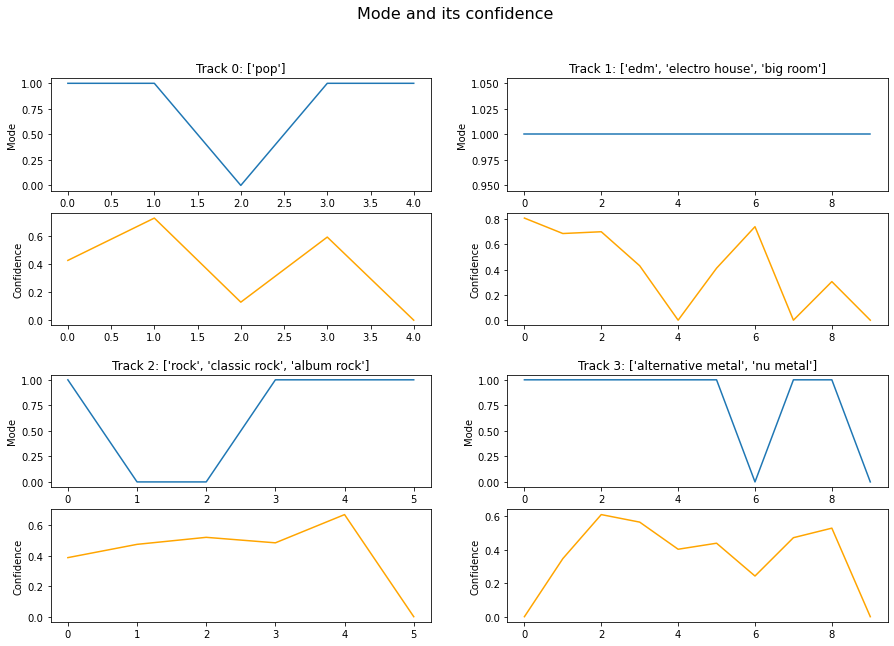

In [22]:
modes = [[x['mode'] for x in X_df['sections'][i]] for i in tracks]
modes_confidence = [[x['mode_confidence'] for x in X_df['sections'][i]] for i in tracks]

visualize(modes, modes_confidence, "Mode")

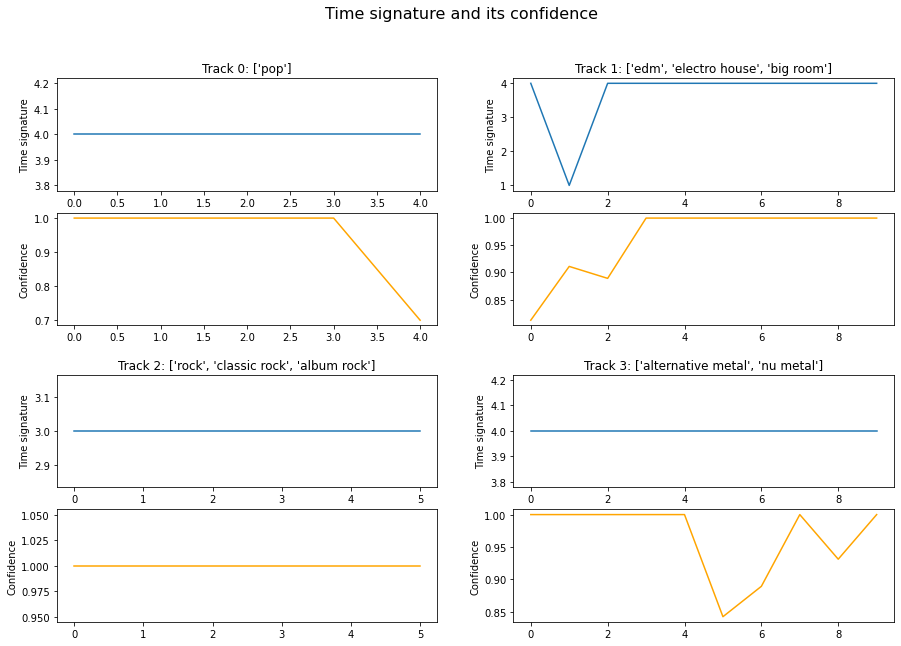

In [23]:
time_signatures = [[x['time_signature'] for x in X_df['sections'][i]] for i in tracks]
time_signatures_confidence = [[x['time_signature_confidence'] for x in X_df['sections'][i]] for i in tracks]

visualize(time_signatures, time_signatures_confidence, "Time signature")

##### Segments

Then let us investigate the features of the segment objects, which are dictionnaries containing lot of features about the segment they correspond to. First we can print several statistic indicators concerning the length of the `segment` feature of each track.

In [24]:
X_df['segments'].apply(lambda x: len(x)).describe()

count    2846.000000
mean      898.797611
std       302.495881
min       312.000000
25%       709.250000
50%       836.000000
75%      1006.000000
max      3378.000000
Name: segments, dtype: float64

Now we are going to visualize the `loudness_start` and `loudness_max` as a curve indexed temporally by the `segment` objects present in the `segments` feature. We plot these two features on the same graph for 4 tracks chosen randomly and we add the genres of the considered track in the graph title so it is possible to guess a link between the curves' shapes and the genres

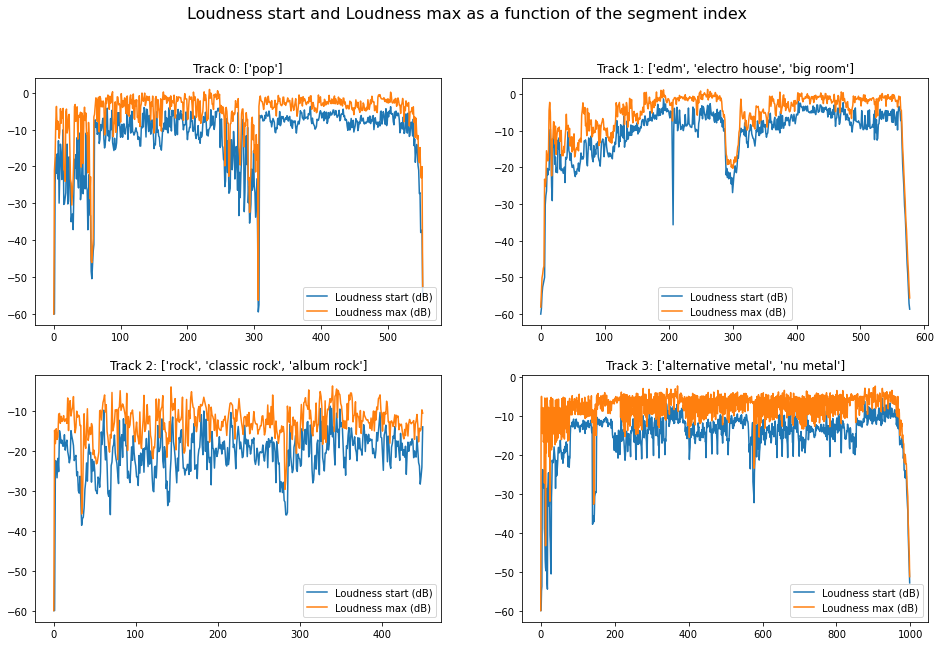

In [25]:
loudnesses_start = [[x['loudness_start'] for x in X_df['segments'][i]] for i in tracks]
loudnesses_max = [[x['loudness_max'] for x in X_df['segments'][i]] for i in tracks]

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
for i, ax in enumerate(axs.ravel()):
    ax.plot(loudnesses_start[i], label='Loudness start (dB)')
    ax.plot(loudnesses_max[i], label='Loudness max (dB)')
    ax.set_title("Track %d: " % i + str(genres[i]))
    ax.legend()

fig.suptitle("Loudness start and Loudness max as a function of the segment index", fontsize=16)
plt.show()

Now you can visualize stackplots of the `pitches` which shows the 12 pitch classes with one color for each pitch class. 
*Pitch* content is given by a “chroma” vector, corresponding to the 12 pitch classes C, C#, D to B, with values ranging from 0 to 1 that describe the relative dominance of every pitch in the chromatic scale. For example a C Major chord would likely be represented by large values of C, E and G (i.e. classes 0, 4, and 7). Vectors are normalized to 1 by their strongest dimension, therefore noisy sounds are likely represented by values that are all close to 1, while pure tones are described by one value at 1 (the pitch) and others near 0.

As can be seen below, the 12 vector indices are a combination of low-power spectrum values at their respective pitch frequencies :

In [39]:
Image(url= "https://developer.spotify.com/assets/audio/Pitch_vector.png", width=900, height=900)

The relative dominance of every pitch in the chromatic scale is described in the `pitches` feature so a stackplot is really adapted for this visualization.

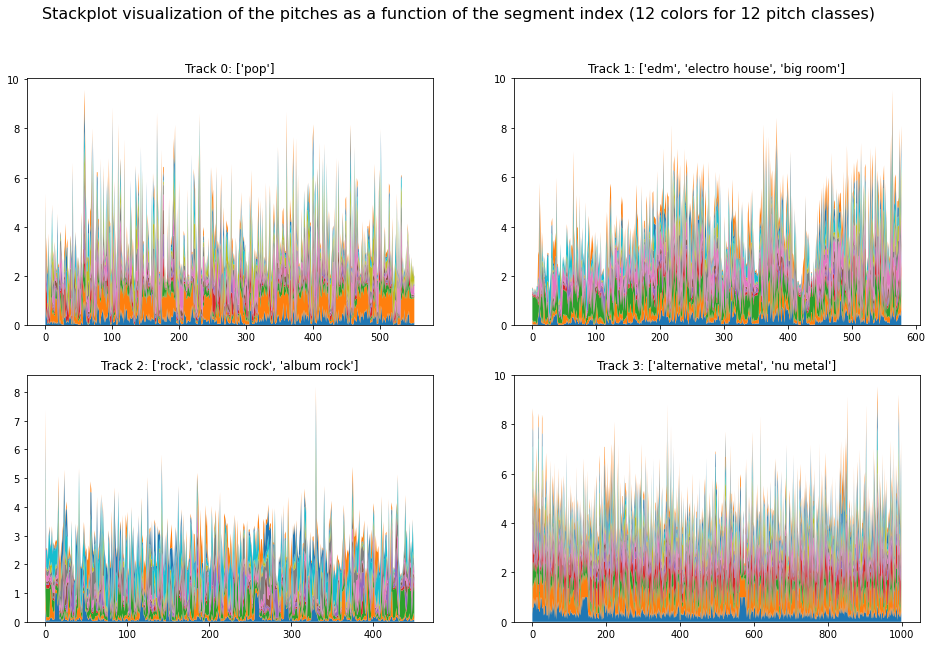

In [41]:
pitches = [[x['pitches'] for x in X_df['segments'][i]] for i in tracks]

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
for i, ax in enumerate(axs.ravel()):
    ax.stackplot(range(len(pitches[i])), np.array(pitches[i]).T, baseline='zero')
    ax.set_title("Track %d: " % i + str(genres[i]))

fig.suptitle("Stackplot visualization of the pitches as a function of the segment index (12 colors for 12 pitch classes)", fontsize=16)
plt.show()

Finally let us provide a more detailed description of the *Timbre* feature which has a quite complex signification but that can be useful to have insights about the instruments used in a track.

*Timbre* is the quality of a musical note or sound that distinguishes different types of musical instruments, or voices. It is a complex notion also referred to as sound color, texture, or tone quality, and is derived from the shape of a segment’s spectro-temporal surface, independently of pitch and loudness. The timbre feature is a vector that includes 12 unbounded values roughly centered around 0. Those values are high level abstractions of the spectral surface, ordered by degree of importance.

For completeness however, the first dimension represents the average loudness of the segment; second emphasizes brightness; third is more closely correlated to the flatness of a sound; fourth to sounds with a stronger attack; etc. See an image below representing the 12 basis functions (i.e. template segments).

In [42]:
Image(url= "https://developer.spotify.com/assets/audio/Timbre_basis_functions.png", width=900, height=900)

The actual timbre of the segment is best described as a linear combination of these 12 basis functions weighted by the coefficient values: timbre = c1 x b1 + c2 x b2 + … + c12 x b12, where c1 to c12 represent the 12 coefficients and b1 to b12 the 12 basis functions as displayed below. Timbre vectors are best used in comparison with each other.

### The genres<a class="anchor" id="genres"></a>

Among the millions of artists that are present in the Spotify dataset their a huge number of genres, the website http://everynoise.com/ provides a list of them and it seems that they are more than 5000. Considering all the existing genres it would have been impossible to perform a multi-label classification task with a reasonnable dataset size. As a result, we have only considered the 25 genres that are the most present in our dataset and we have adapted our metric to suit these genres.

The 25 genres that we have considered are:
- rock
- pop
- latin
- edm
- rap
- dance pop
- pop dance
- electro house
- alternative metal
- hip hop
- pop rap
- tropical
- trap
- nu metal
- classic rock
- post-teen pop
- album rock
- latin pop
- southern hip hop
- hard rock
- gangster rap
- electropop
- big room
- classical
- reggaeton

As you can see they are quite various and they almost have a quite distinct identity, e.g. we don't have genres that are all similar.

First we can see if our genres are uniformly distributed or if our dataset is imbalanced.

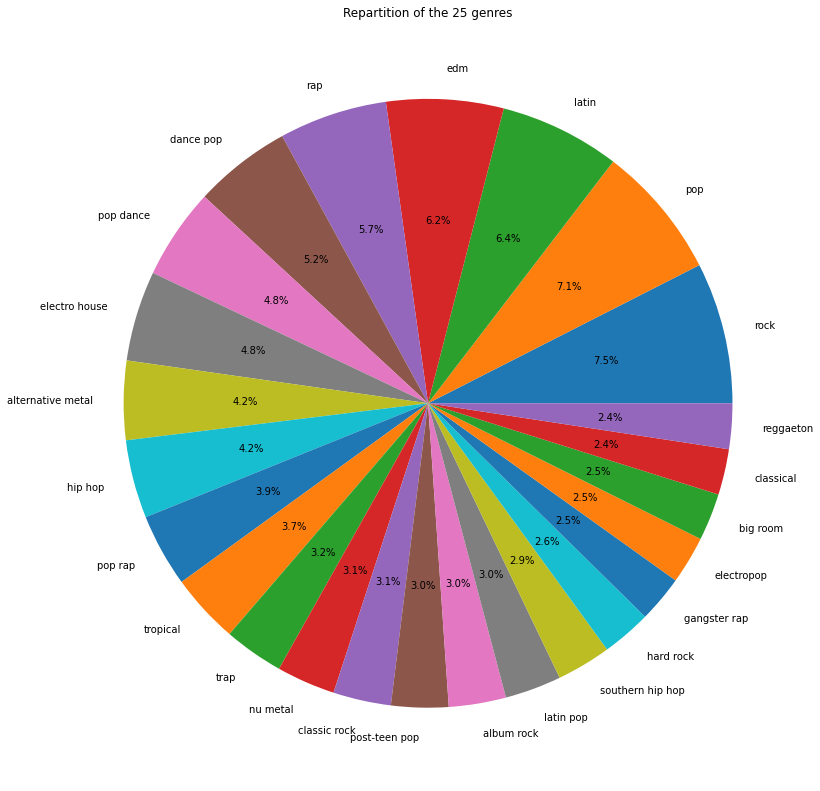

In [27]:
y_df.sum().plot(figsize=(14,14), kind='pie', title='Repartition of the 25 genres', ylabel='', autopct='%1.1f%%')
plt.show()

It seems that the genres are quite uniformly distributed since their proportion in the dataset varies from 2.4% to 7.5%. For a multi-label classification problem we can be quite satisfied with this repartition.

Since we have a multi-label classification problem it can be interesting to see the average number of genres for a track of the dataset.

In [28]:
print("In our dataset the average number of genres for each track is %.3f." %(y_df.sum(axis=1).mean()))

In our dataset the average number of genres for each track is 2.662.


### Performance metric<a class="anchor" id="metric"></a>



Your algorithm will be evaluated based on two scores:

   - Jaccard error
   - EMD (Earth Mover's Distance) score

You want to aim for the best score you can achieve in both metric which is 0.

#### Jaccard error

The Jaccard score is a measure of similarity between 2 sets. For a sample $i$ it is defined as the size of the intersection of the true and predicted genres divided by the union :
$$\mathrm{Jaccard_\ score}(y^{true}_i,y^{pred}_i)=\frac {|y^{true}_i\cap y^{pred}_i|}{|y^{true}_i\cup y^{pred}_i|}$$

For evaluating a complete dataset, we take the average over the samples, namely :
$$\mathrm{Jaccard_\ score}(y^{true},y^{pred})= \frac 1 n \sum_{i=1}^n \mathrm{Jaccard_\ score}(y^{true}_i,y^{pred}_i)$$

Finally, in order to have a metric to minimize we take the Jaccard Error, which is just 1 - Jaccard Score.

You can read more on the Jaccard score in Scikit-learn definition (which is the implementation we are using here).


#### Earth Mover's Distance (EMD) score

EMD is using precalculated minimum distances between each of the 25 genres considered here to know the distance between the true genres ($y^{true}$) and the predicted genres ($y^{pred}$).

The formula for EMD is:
$$\mathrm{EMD}(y^{true},y^{pred})= \frac{\sum\limits_{i=1}^{m}\sum\limits_{j=1}^{n}f_{i,j}d_{i,j}}{\sum\limits_{i=1}^{m}\sum\limits_{j=1}^{n}f_{i,j}}
$$

where $m$ is the number of true genres and $n$ is the number of predicted genres. $d_{i,j}$ is the distance between genre $i$ and genre $j$. $f_{i,j}$ is the solution to the optimization problem of transforming predicted genres to true genres.

The intuition behind this formula is that some genres are clearly more similar than others. For instance to miss-classify a *pop* song into a *classical* song is such a huge mistake, because the two genres are really different. However, to miss-classify a *pop* song into a *post-teen pop* song is more acceptable, as the genres are quite similar. The EMD score gives a measure of *how close you are in the space of genres* to the true genres of the music.

You can read more about Earth Mover’s Distance (EMD) in Wikipedia. We are using Pot Python libarary to perform the calculations, if you are interested in the implementation details you can also look into this.
For the computation of the ground metric $(d_{i,j})$, we used a measure of similarity given implictly in the website https://everynoise.com.


## Submission <a class="anchor" id="submission"></a>

In [29]:
X_train, y_train, X_test, y_test = iterative_train_test_split(X_df.to_numpy(), y_df.to_numpy(), test_size=0.3)
X_train, y_train = pd.DataFrame(X_train, columns=X_df.columns), pd.DataFrame(y_train, columns=y_df.columns)
X_test, y_test = pd.DataFrame(X_test, columns=X_df.columns), pd.DataFrame(y_test, columns=y_df.columns)

In [30]:
cols = [
    'danceability',
    'energy',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo', 
    'mode', 
    'duration_ms', 
    'time_signature', 
    'key',
    'loudness'
]

transformer = make_column_transformer(
    ('passthrough', cols)
)

pipe = make_pipeline(
    transformer,
    DecisionTreeClassifier()
)


def get_estimator():
    return pipe

In [31]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['danceability', 'energy',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'mode',
                                                   'duration_ms',
                                                   'time_signature', 'key',
                                                   'loudness'])])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [32]:
y_pred = pipe.predict(X_test)
jac_score = jaccard_score(y_test.values, y_pred, average='samples')
emd_score = EMDScore()(y_test.values, y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
jac_score, emd_score

(0.3330289766179696, 0.400377335840342)